<a href="https://colab.research.google.com/github/camdenmcgath/Artificial-Judge/blob/master/supreme_court_judge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 Gather Necessary Data and Libraries

In [ ]:
import pandas as pd
import re
import random
from tabulate import tabulate
import evaluate
import numpy as np
import transformers as trans
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer
import torch
from torch.optim import AdamW, lr_scheduler
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline, BSpline
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tqdm import trange
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:2048"


In [ ]:
cases = pd.read_csv("justice.csv")
#drop irrelevant columns
cases.drop(columns=['Unnamed: 0', 'ID', 'name', 'href', 'docket', 'term',  
                    'majority_vote', 'minority_vote', 'decision_type', 'disposition', 'issue_area'], inplace=True)
cases.dropna(inplace=True)


# 2 Preprocess Data

## 2.1 Normalization

In [ ]:
#change winner column from boolean to 0 and 1
cases = cases.rename(columns={'first_party_winner': 'winning_party_idx'})
for i, row in cases.iterrows():
    if row['winning_party_idx'] == True:
        cases.loc[i, 'winning_party_idx'] = 0
    else:
        cases.loc[i, 'winning_party_idx'] = 1

Create a mirrored case for each case, where the parties are swapped to prevent favoring first_party

In [ ]:
mirrored_cases = cases.copy()
mirrored_cases['first_party'], mirrored_cases['second_party'] = mirrored_cases['second_party'], mirrored_cases['first_party']
mirrored_cases['winning_party_idx'] = (mirrored_cases['winning_party_idx'] == 0).astype(int)
mirrored_cases.reset_index(drop=True, inplace=True)

cases = pd.concat([cases, mirrored_cases])
cases.reset_index(drop=True, inplace=True)
print(f'There are {len(cases)} cases.')
print(f'There are {len(cases[cases["winning_party_idx"]==0])} rows for class 0.')
print(f'There are {len(cases[cases["winning_party_idx"]==1])} rows for class 1.')

There are 6572 cases.
There are 3286 rows for class 0.
There are 3286 rows for class 1.


In this dataset, text comes with html tags, so begin by removing those tags from the text. Then remove any non-aphanumeric characters. Apsotrophe's were chosen to be left in due to their indication of possessiveness and strong impact in legal semantics. 

In [ ]:
cases['facts'] = cases['facts'].str.replace(r'<[^<]+?>', '', regex=True)
cases['facts'] = cases['facts'].str.replace(r'[^a-zA-Z0-9\']', ' ', regex=True)
cases['first_party'] = cases['first_party'].str.replace(r'[^a-zA-Z0-9\']', ' ', regex=True)
cases['second_party'] = cases['second_party'].str.replace(r'[^a-zA-Z0-9\']', ' ', regex=True)
cases['facts'] = cases.apply(lambda x: f"{x['first_party']} [SEP] {x['second_party']} [SEP] {x['facts']}", axis=1)

Change facts_len from characters to words. This makes predicting the number of tokens more accuracte. 

In [ ]:
def word_count(text):
  return len(text.split())

cases['facts_len'] = cases['facts'].apply(word_count)
cases['facts_len'].describe()

count    6572.000000
mean      184.493914
std        85.980464
min         7.000000
25%       127.000000
50%       173.000000
75%       229.000000
max       993.000000
Name: facts_len, dtype: float64

Visualized the amount of data below 450 which was the threshold deemed to fit under token limit of 512.

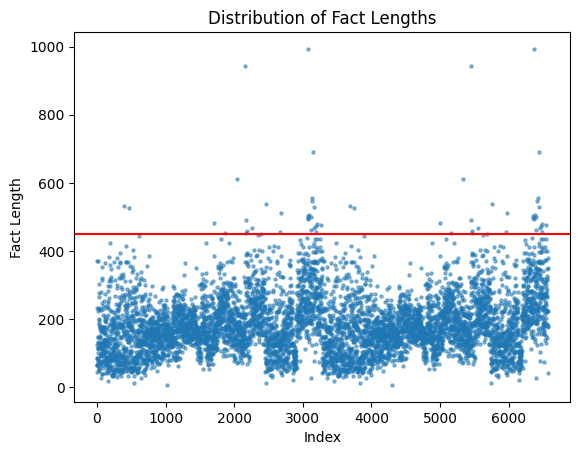


Percentage of cases with fact word no greater than 400: 99.12%


In [ ]:
plt.scatter(range(len(cases['facts_len'])), cases['facts_len'], s=5, alpha=0.5)
plt.axhline(y=450, color='red')
plt.xlabel('Index')
plt.ylabel('Fact Length')
plt.title('Distribution of Fact Lengths')
plt.show()
num_short_facts = len(cases[cases['facts_len'] <= 450])
percentage_short_facts = num_short_facts / len(cases) * 100
print(f"\nPercentage of cases with fact word no greater than 450: {percentage_short_facts:.2f}%")

In order to make sure no data is truncated, we stop word lengths at 450 (max token limit of 512). We want to avoid training BERT on cases with incomplete facts as it may cause BERT to learn relationships and draw incorrect conclusions amongst text features it otherwise would not have. At this point drop all features except the text and label (facts and winner idx)

In [ ]:
cases = cases[cases['facts_len'] <= 450]
print(cases['facts_len'].describe())
cases = cases.drop(columns=['first_party', 'second_party', 'facts_len'])

count    6514.000000
mean      181.362604
std        78.750375
min         7.000000
25%       127.000000
50%       173.000000
75%       228.000000
max       449.000000
Name: facts_len, dtype: float64


## 2.2 Tokenization
Tokenization code citation: https://towardsdatascience.com/fine-tuning-bert-for-text-classification-54e7df642894#e7cb

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Get a random sample of facts and output the corresponding word tokens and ID's. This helps ensure the tokenizer is woking correctly.



In [ ]:
text = cases.facts.values
labels = cases.winning_party_idx.values
print(type(labels))
def print_rand_sentence():
  '''Displays the tokens and respective IDs of a random text sample'''
  index = random.randint(0, len(text)-1)
  table = np.array([tokenizer.tokenize(text[index]), 
                    tokenizer.convert_tokens_to_ids(tokenizer.tokenize(text[index]))]).T
  print(tabulate(table,
                 headers = ['Tokens', 'Token IDs'],
                 tablefmt = 'fancy_grid'))

print_rand_sentence()

<class 'numpy.ndarray'>
╒══════════════╤═════════════╕
│ Tokens       │   Token IDs │
╞══════════════╪═════════════╡
│ mark         │        2928 │
├──────────────┼─────────────┤
│ close        │        2485 │
├──────────────┼─────────────┤
│ [SEP]        │         102 │
├──────────────┼─────────────┤
│ sha          │       21146 │
├──────────────┼─────────────┤
│ ##kur        │       18569 │
├──────────────┼─────────────┤
│ muhammad     │        7187 │
├──────────────┼─────────────┤
│ aka          │        9875 │
├──────────────┼─────────────┤
│ john         │        2198 │
├──────────────┼─────────────┤
│ e            │        1041 │
├──────────────┼─────────────┤
│ me           │        2033 │
├──────────────┼─────────────┤
│ ##ase        │       11022 │
├──────────────┼─────────────┤
│ [SEP]        │         102 │
├──────────────┼─────────────┤
│ prison       │        3827 │
├──────────────┼─────────────┤
│ officials    │        4584 │
├──────────────┼─────────────┤
│ sentenced    

Define a preprocessing function to encode input text with the Bert Tokenizer. Create attention masks as well so BEert knows what is relevant and output an example of the encoded tesnor to see padded values (0) and [CLS] 101 and [SEP] 102 tokens. 

In [ ]:
token_id = []
attention_masks = []

def preprocessing(input_text, tokenizer):
  '''
  Returns <class transformers.tokenization_utils_base.BatchEncoding> with the following fields:
    - input_ids: list of token ids
    - token_type_ids: list of token type ids
    - attention_mask: list of indices (0,1) specifying which tokens should considered by the model (return_attention_mask = True).
  '''
  return tokenizer.encode_plus(
                        input_text,
                        add_special_tokens = True,
                        max_length = 512,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt'
                   )


for sample in text:
  encoding_dict = preprocessing(sample, tokenizer)
  token_id.append(encoding_dict['input_ids']) 
  attention_masks.append(encoding_dict['attention_mask'])


token_id = torch.cat(token_id, dim = 0)
attention_masks = torch.cat(attention_masks, dim = 0)
labels = torch.tensor(labels.astype(np.int64))
token_id[6]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


tensor([  101, 18906,  3630,   102,  4307,  4126, 11538,  3222,   102,  1996,
         4307,  4126, 11538,  3222,  2001,  2580,  2000,  8556,  4114,  4126,
         1999,  4307,  4789, 18906,  3630,  1998,  3782,  4003,  2072,  2020,
         2610,  3738,  1996,  3222,  2359,  1996,  3738,  2000, 19919, 27081,
         2000,  2019,  4812,  1997,  1037, 10869,  5414,  2030,  5414, 11420,
        14513,  3388,  2006,  2337,  1022,  3380,  1996, 18131,  3648,  1999,
         1996,  4984,  2457,  1997,  5660,  2221,  3133,  2019,  2344,  9034,
         1996,  9964,  2545,  2000,  3711,  2077,  1996,  3222,  2104,  1037,
         3946,  1997, 15403, 27081,  2000,  2019,  4307, 11671,  2006,  2337,
         2484,  3380,  1996,  3738,  2596,  2021,  2027,  4188,  2000,  3437,
         2151,  3980, 16418,  2037,  2157,  2114,  2969,  4297, 20026, 12758,
         2104,  1996,  3587,  7450,  2006,  2233,  2538,  3380,  1996,  3222,
         6406,  1037,  4367,  1999,  1996,  4984,  2457,  1998, 

Tes to see if the attention mask is working properly.

In [ ]:
def print_rand_sentence_encoding():
  '''Displays tokens, token IDs and attention mask of a random text sample'''
  index = random.randint(0, len(text) - 1)
  tokens = tokenizer.tokenize(tokenizer.decode(token_id[index]))
  token_ids = [i.numpy() for i in token_id[index]]
  attention = [i.numpy() for i in attention_masks[index]]

  table = np.array([tokens, token_ids, attention]).T
  print(tabulate(table, 
                 headers = ['Tokens', 'Token IDs', 'Attention Mask'],
                 tablefmt = 'fancy_grid'))

print_rand_sentence_encoding()

╒══════════════╤═════════════╤══════════════════╕
│ Tokens       │   Token IDs │   Attention Mask │
╞══════════════╪═════════════╪══════════════════╡
│ [CLS]        │         101 │                1 │
├──────────────┼─────────────┼──────────────────┤
│ ci           │       25022 │                1 │
├──────────────┼─────────────┼──────────────────┤
│ ##ti         │        3775 │                1 │
├──────────────┼─────────────┼──────────────────┤
│ ##bank       │        9299 │                1 │
├──────────────┼─────────────┼──────────────────┤
│ n            │        1050 │                1 │
├──────────────┼─────────────┼──────────────────┤
│ a            │        1037 │                1 │
├──────────────┼─────────────┼──────────────────┤
│ [SEP]        │         102 │                1 │
├──────────────┼─────────────┼──────────────────┤
│ st           │        2358 │                1 │
├──────────────┼─────────────┼──────────────────┤
│ ##ok         │        6559 │                1 │


Split 80% training and 20% validation indices, and pss the respective indices in to the TensorDataset with the token ids, attention masks and labels. 



In [ ]:
train_idx, val_idx = train_test_split(
  np.arange(len(labels)),
  test_size=0.2,
  shuffle=True,
  stratify=labels   
)

In [ ]:
# Train and validation sets
train_dataset = TensorDataset(token_id[train_idx], 
                          attention_masks[train_idx], 
                          labels[train_idx])

val_dataset = TensorDataset(token_id[val_idx], 
                        attention_masks[val_idx], 
                        labels[val_idx])

## 3 Models

## 3.1 Vanilla Pytorch
Much thanks again to Nicolo Cosmio Albanese for the vanilla Pytroch implementation: https://towardsdatascience.com/fine-tuning-bert-for-text-classification-54e7df642894#e7cb

### 3.1.1 Dataloaders and Other Initializations

In [ ]:
# Prepare DataLoader
train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = 16
        )

validation_dataloader = DataLoader(
            val_dataset,
            sampler = SequentialSampler(val_dataset),
            batch_size = 16
        )

In [ ]:
# Load the BertForSequenceClassification model
model = BertForSequenceClassification.from_pretrained(
    'bert-large-uncased',
    num_labels = 2,
    output_attentions = False,
    output_hidden_states = False,
)

# Recommended learning rates (Adam): 5e-5, 3e-5, 2e-5. See: https://arxiv.org/pdf/1810.04805.pdf
optimizer = torch.optim.AdamW(model.parameters(), 
                              lr = 5e-5,
                              eps = 1e-08
                              )

# Run on GPU
model.cuda()

Functions to calculate accuracies when validating the model

In [ ]:
def b_tp(preds, labels):
  '''Returns True Positives (TP): count of correct predictions of actual class 1'''
  return sum([preds == labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_fp(preds, labels):
  '''Returns False Positives (FP): count of wrong predictions of actual class 1'''
  return sum([preds != labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_tn(preds, labels):
  '''Returns True Negatives (TN): count of correct predictions of actual class 0'''
  return sum([preds == labels and preds == 0 for preds, labels in zip(preds, labels)])

def b_fn(preds, labels):
  '''Returns False Negatives (FN): count of wrong predictions of actual class 0'''
  return sum([preds != labels and preds == 0 for preds, labels in zip(preds, labels)])

def b_metrics(preds, labels):
  '''
  Returns the following metrics:
    - accuracy    = (TP + TN) / N
    - precision   = TP / (TP + FP)
    - recall      = TP / (TP + FN)
    - specificity = TN / (TN + FP)
  '''
  preds = np.argmax(preds, axis = 1).flatten()
  labels = labels.flatten()
  tp = b_tp(preds, labels)
  tn = b_tn(preds, labels)
  fp = b_fp(preds, labels)
  fn = b_fn(preds, labels)
  b_accuracy = (tp + tn) / len(labels)
  b_precision = tp / (tp + fp) if (tp + fp) > 0 else 'nan'
  b_recall = tp / (tp + fn) if (tp + fn) > 0 else 'nan'
  b_specificity = tn / (tn + fp) if (tn + fp) > 0 else 'nan'
  return b_accuracy, b_precision, b_recall, b_specificity

### 3.1.2 Pytorch Manual Training Loop

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Recommended number of epochs: 2, 3, 4. See: https://arxiv.org/pdf/1810.04805.pdf
epochs = 5

for _ in trange(epochs, desc = 'Epoch'):
    
    # ========== Training ==========
    
    # Set model to training mode
    model.train()
    
    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        optimizer.zero_grad()
        # Forward pass
        train_output = model(b_input_ids, 
                             token_type_ids = None, 
                             attention_mask = b_input_mask, 
                             labels = b_labels)
        # Backward pass
        train_output.loss.backward()
        optimizer.step()
        # Update tracking variables
        tr_loss += train_output.loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    # ========== Validation ==========

    # Set model to evaluation mode
    model.eval()

    # Tracking variables 
    val_accuracy = []
    val_precision = []
    val_recall = []
    val_specificity = []

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
          # Forward pass
          eval_output = model(b_input_ids, 
                              token_type_ids = None, 
                              attention_mask = b_input_mask)
        logits = eval_output.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # Calculate validation metrics
        b_accuracy, b_precision, b_recall, b_specificity = b_metrics(logits, label_ids)
        val_accuracy.append(b_accuracy)
        # Update precision only when (tp + fp) !=0; ignore nan
        if b_precision != 'nan': val_precision.append(b_precision)
        # Update recall only when (tp + fn) !=0; ignore nan
        if b_recall != 'nan': val_recall.append(b_recall)
        # Update specificity only when (tn + fp) !=0; ignore nan
        if b_specificity != 'nan': val_specificity.append(b_specificity)

    print('\n\t - Train loss: {:.4f}'.format(tr_loss / nb_tr_steps))
    print('\t - Validation Accuracy: {:.4f}'.format(sum(val_accuracy)/len(val_accuracy)))
    print('\t - Validation Precision: {:.4f}'.format(sum(val_precision)/len(val_precision)) if len(val_precision)>0 else '\t - Validation Precision: NaN')
    print('\t - Validation Recall: {:.4f}'.format(sum(val_recall)/len(val_recall)) if len(val_recall)>0 else '\t - Validation Recall: NaN')
    print('\t - Validation Specificity: {:.4f}\n'.format(sum(val_specificity)/len(val_specificity)) if len(val_specificity)>0 else '\t - Validation Specificity: NaN')


## 3.2 Huggingface's Transformers Trainer Method
Anther approach to the one done above on the same preprocessed data. Results should come out the same

### 3.2.1 Resplitting Training and Validation Data

In [ ]:
train_facts, val_facts, train_winners,  val_winners = train_test_split(
    cases['facts'], cases['winning_party_idx'], test_size=0.2, random_state=42)

def describe_facts(txt_df):
  txt_df2 = txt_df.copy()
  txt_df2['word_count'] = txt_df.apply(word_count)
  print(txt_df2['word_count'].describe())

#ensure train/test data has similar text size distribution
describe_facts(train_facts)
describe_facts(val_facts)
print(train_winners.describe())
print(val_winners.describe())

### 3.2.2 Re-encoding Using Custom Dataset

In [ ]:

train_facts, val_facts = train_facts.tolist(), val_facts.tolist()
train_winners, val_winners = [str(i) for i in train_winners], [str(i) for i in val_winners]

train_encodings = tokenizer(train_facts, padding=True)
val_encodings = tokenizer(val_facts, padding=True)

In [ ]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(int(self.labels[idx]))
        type(item)
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TextDataset(train_encodings, train_winners)
val_dataset = TextDataset(val_encodings, val_winners)


### 3.2.3 Fine Tune

In [ ]:
#Load pretrained model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', 
                                                      num_labels=2, 
                                                      #hidden_dropout_prob=0.4,
                                                      #attention_probs_dropout_prob=0.4
                                                      )

training_args = TrainingArguments(
    output_dir="test_trainer", 
    logging_dir='logs', 
    evaluation_strategy="epoch",
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    gradient_accumulation_steps=1,
    learning_rate=5e-5,
    logging_steps=50,
)
metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    return metric.compute(predictions=predictions, references=labels)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)


### 3.2.4 Train

In [ ]:
trainer.train()

In [ ]:
# Evaluate on the validation set
result = trainer.predict(val_dataset)

# Extract the predicted and true labels from the evaluation results
y_pred = result.predictions.argmax(axis=1)
y_true = result.label_ids

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()